In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import sklearn.metrics
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

data = pd.read_parquet("/mnt/DP_disk1/ht/datasets/autofe/recsys2023/recsys2023_train.parquet")
day_i_y = 66
train_df = data[data['f_1'] < day_i_y]
test_df = data[data['f_1'] == day_i_y]
target_label = "is_installed"

In [2]:
from pyrecdp.autofe import AutoFE

pipeline = AutoFE(dataset=train_df, label=target_label, time_series = 'f_1')
transformed_train_df = pipeline.fit_transform()

test_pipeline = AutoFE.clone_pipeline(pipeline, test_df)
transformed_test_df = test_pipeline.transform()

JAVA_HOME is not set, use default value of /usr/lib/jvm/java-8-openjdk-amd64/
AutoFE started to profile data


TypeConvertFeatureGenerator: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 936.12it/s]


AutoFE started to create data pipeline


/root/anaconda3/envs/autofe/lib/python3.8/site-packages/pyrecdp/core/dataframe.py:19: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'may_sample' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  def may_sample(df, nrows = 100000):


We exclude some Feature Engineer Generator as listed, you can use 'include_op = ["XXXFeatureGenerator"]'  to re-add them, exclude_op list ['TargetEncodeFeatureGenerator']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 526696.67it/s]


Feature List generated, using analyzed feature tags to create data pipeline


DropUselessFeatureGenerator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 641.80it/s]


AutoFE started to fit_transform data
execute with pandas started ...
execute DataFrame started ...
  execute DataFrame took 0.5869688931852579 sec
execute type_infer started ...
  execute type_infer took 12.675634244456887 sec
execute time_series_infer started ...
  execute time_series_infer took 9.952113032341003e-06 sec
execute astype started ...
  execute astype took 0.3580596651881933 sec
execute fillna started ...
  execute fillna took 2.1583028454333544 sec
execute group_categorify started ...


GroupCategorify: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:18<00:00,  2.27it/s]


  execute group_categorify took 21.72796008735895 sec
execute count_encode started ...


CountEncode: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:38<00:00,  2.14it/s]


  execute count_encode took 43.82011013105512 sec
execute DataFrame started ...
  execute DataFrame took 9.588897228240967e-06 sec
execute lightgbm started ...


/root/anaconda3/envs/autofe/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 27874, number of negative: 130280
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16755
[LightGBM] [Info] Number of data points in the train set: 158154, number of used features: 204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176246 -> initscore=-1.541992
[LightGBM] [Info] Start training from score -1.541992
[100]	valid_0's auc: 0.867189
  execute lightgbm took 12.978025479242206 sec
execute with pandas took 94.30572405084968 sec
execute with pandas started ...
execute DataFrame started ...
  execute DataFrame took 0.005016816779971123 sec
execute type_infer started ...
  execute type_infer took 0.1380099430680275 sec
execute time_series_infer started ...
  execute time_series_infer took 8.385628461837769e-06 sec
execute astype started ...
  execute astype took 0.029249411076307297 sec
execute fill

GroupCategorify: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:12<00:00,  3.27it/s]


  execute group_categorify took 13.045525999739766 sec
execute count_encode started ...


CountEncode: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:13<00:00,  6.09it/s]


  execute count_encode took 14.220103241503239 sec
execute with pandas took 27.50875983387232 sec


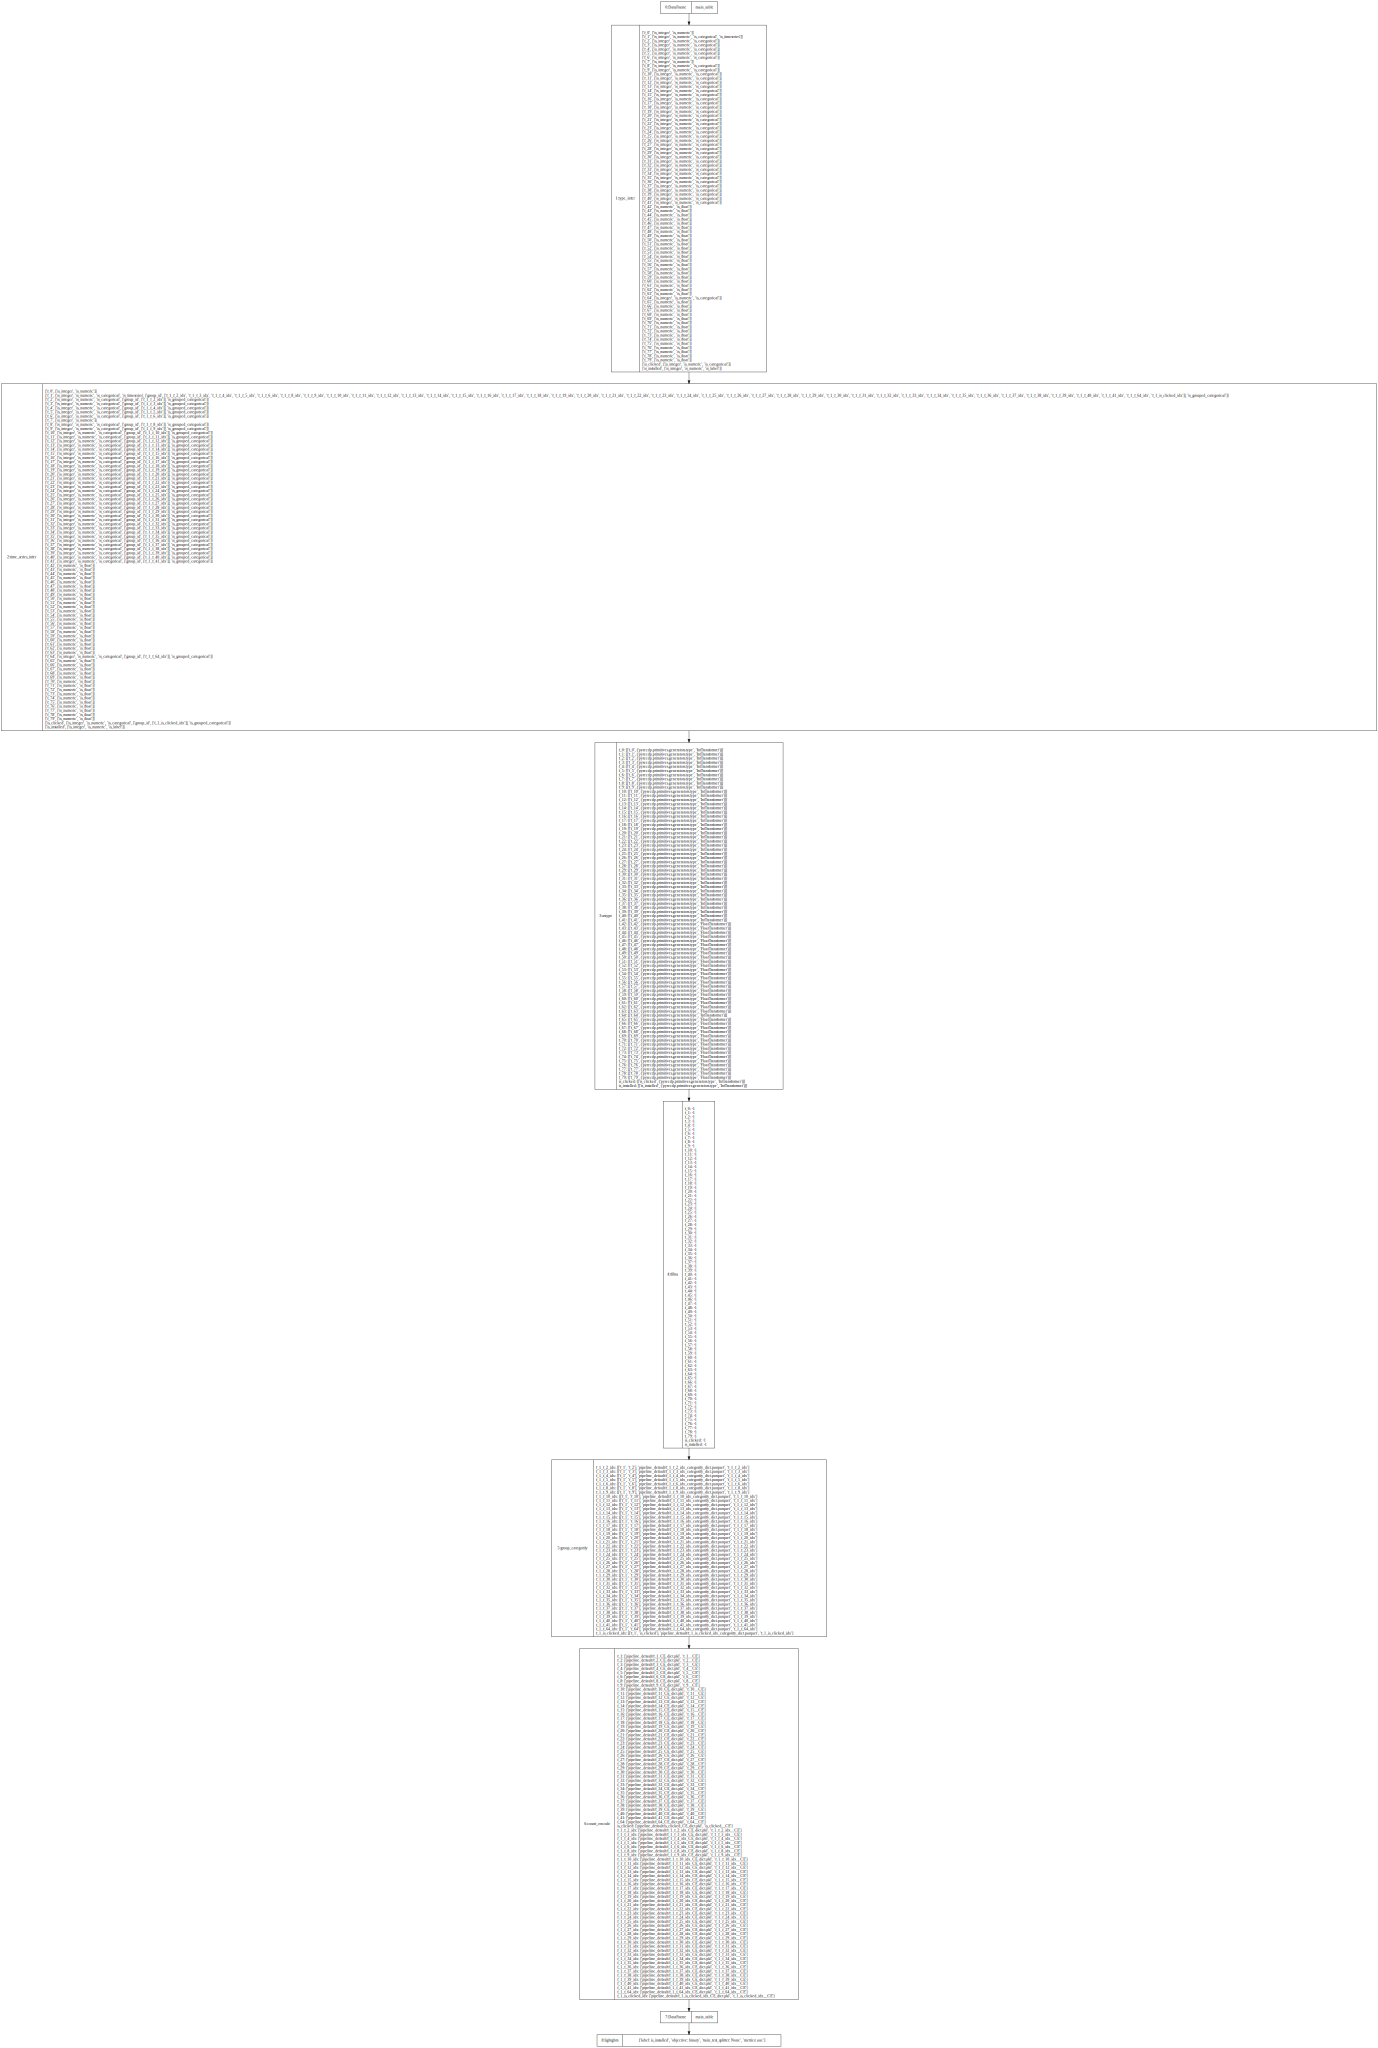

In [3]:
pipeline.plot()

<Axes: >

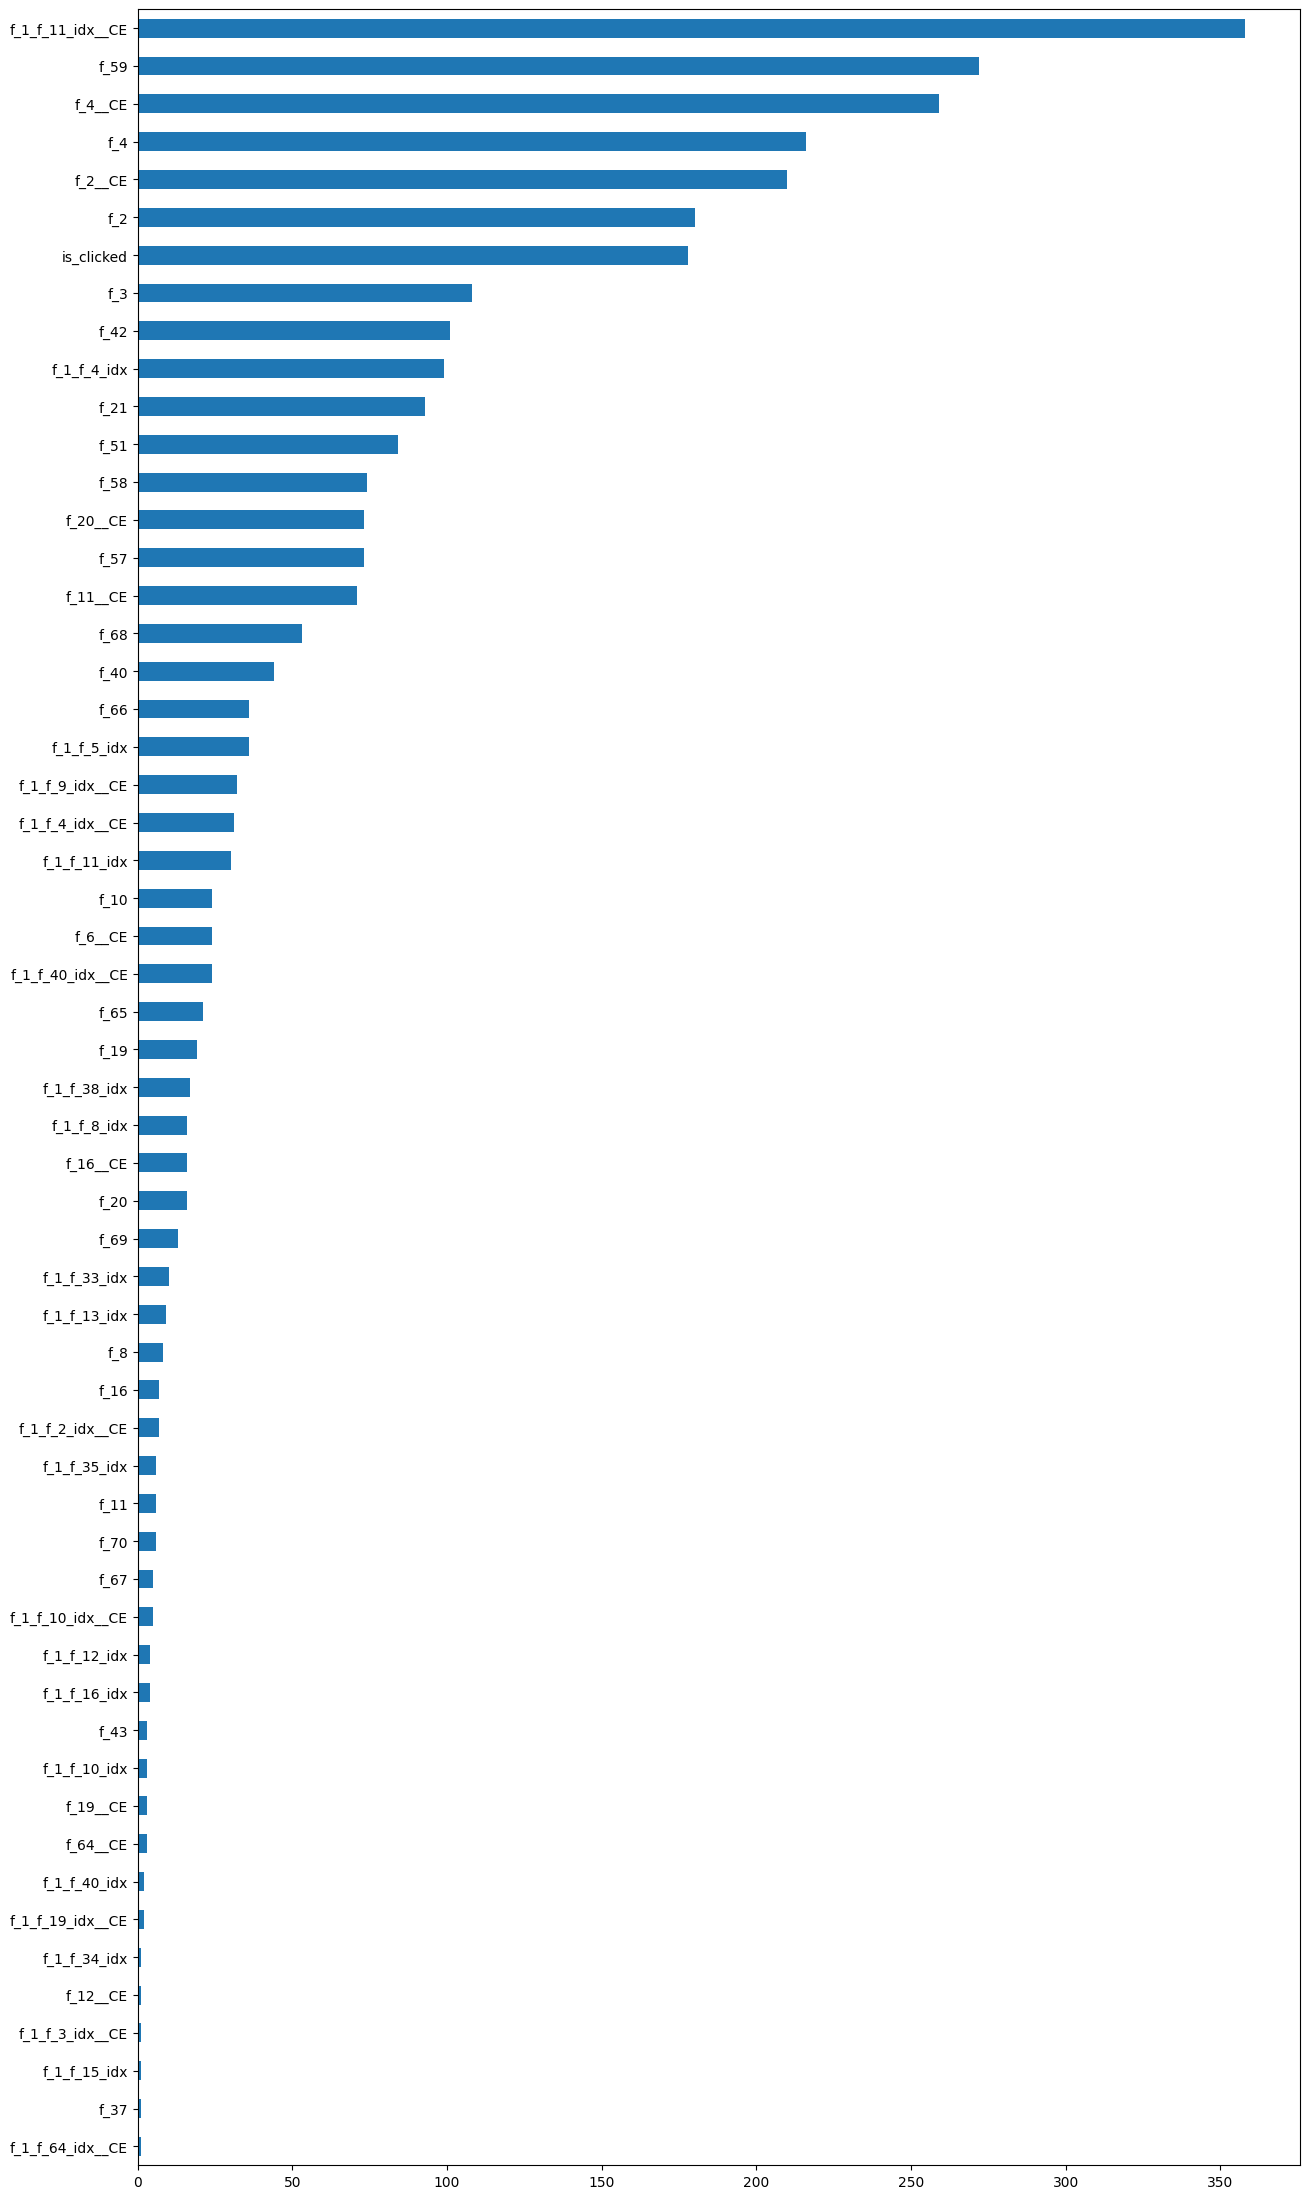

In [4]:
pipeline.feature_importance()

In [6]:
from pyrecdp.core.utils import Timer

features_train = [i for i in transformed_train_df.columns if i != target_label]
train_df = transformed_train_df
test_df = transformed_test_df

import lightgbm as lgb
lgbm_parms = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'],
    'num_leaves': 63,
    'max_bin': 255,
    'num_trees': 10000,
    'min_data_in_leaf': 20,
    'min_sum_hessian_in_leaf': 5.0,
    'is_enable_sparse': True,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'early_stopping_rounds':1000,
}

with Timer(f"Train until day {day_i_y}, and valid on day {day_i_y}"):
    dtrain = lgb.Dataset(
        data=train_df[features_train], 
        label=train_df[target_label]
    )
    dvalid = lgb.Dataset(
        data=test_df[features_train], 
        label=test_df[target_label]
    )
    
    model = lgb.train(
        lgbm_parms,
        train_set=dtrain,
        valid_sets=[dtrain, dvalid],
        verbose_eval=1000,)

Train until day 66, and valid on day 66 started ...


/root/anaconda3/envs/autofe/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/root/anaconda3/envs/autofe/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 588239, number of negative: 2799641
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17140
[LightGBM] [Info] Number of data points in the train set: 3387880, number of used features: 204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.173630 -> initscore=-1.560113
[LightGBM] [Info] Start training from score -1.560113
Training until validation scores don't improve for 1000 rounds
[1000]	training's binary_logloss: 0.234085	training's auc: 0.929859	valid_1's binary_logloss: 0.280227	valid_1's auc: 0.910664
[2000]	training's binary_logloss: 0.229707	training's auc: 0.932632	valid_1's binary_logloss: 0.276752	valid_1's auc: 0.911987
[3000]	training's binary_logloss: 0.227277	training's auc: 0.934307	valid_1's binary_logloss: 0.275912	valid_1's au